# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
***
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1.   ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2.   情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
1.   抽出された事例をランダムに並び替える．
2.   抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

In [0]:
!wc -l ./newsCorpora.csv

422937 ./newsCorpora.csv


In [0]:
!head -10 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [0]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


## 51. 特徴量抽出
***
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [0]:
import string
import re

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)  # 記号をスペースに置換
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換

  return text

In [0]:
# データの再結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)  # indexを振りなおす

# 前処理の実施
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))

df.head()

,TITLE,CATEGORY
0,refile update 0 european car sales up for sixt...,b
1,amazon plans to fight ftc over mobile app purc...,t
2,kids still get codeine in emergency rooms desp...,m
3,what on earth happened between solange and jay...,e
4,nato missile defense is flight tested over hawaii,b


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

# データの分割
train_valid, test = df[:len(train) + len(valid)], df[len(train) + len(valid):]

# TfidfVectorizer
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない
X_test = vec_tfidf.transform(test['TITLE'])

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
X_train.to_csv('./X_train.txt', sep='\t', index=False)
X_valid.to_csv('./X_valid.txt', sep='\t', index=False)
X_test.to_csv('./X_test.txt', sep='\t', index=False)

X_train.head()

,0m,0million,0nd,0s,0st,0th,0th birthday,aa,aaliyah,abbvie,abc,about,about the,about to,above,abramson,abuse,ac,ac dc,accelerates,access,accident,account,accused,accused of,accuses,ackman,acquire,across,act,acting,action,activists,actor,actress,actually,ad,adam,adds,adds to,...,would,wrapup,wrapup us,wren,wren scott,wrong,wsj,wti,xbox,yahoo,year,year high,year low,year old,years,years after,yellen,yellen says,yellen testimony,yen,yet,yield,yields,york,york ap,york times,you,you can,you need,you to,young,your,your mother,yr,yr high,yuan,zac,zac efron,zendaya,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 52. 学習
***
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [0]:
from sklearn.linear_model import LogisticRegression

# モデルの学習
lg = LogisticRegression(random_state=123, max_iter=10000)
lg.fit(X_train, train['CATEGORY'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 53. 予測
***
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [0]:
import numpy as np

def score_lg(lg, X):
  return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]

In [0]:
train_pred = score_lg(lg, X_train)
test_pred = score_lg(lg, X_test)

train_pred

[array([0.8402725 , 0.67906432, 0.55642575, ..., 0.86051523, 0.61362406,
        0.90827641]), array(['b', 't', 'm', ..., 'b', 'm', 'e'], dtype=object)]

In [0]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.927
正解率（評価データ）：0.885


## 55. 混同行列の作成
***
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

[[4344   93    8   56]
 [  52 4173    2    8]
 [  96  125  494   13]
 [ 192  133    7  888]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


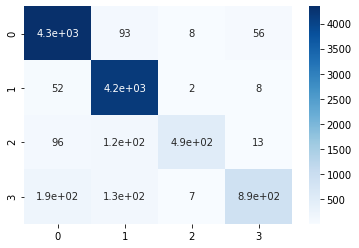

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()

[[528  20   2  13]
 [ 12 516   1   1]
 [ 11  26  52   2]
 [ 38  26   1  87]]


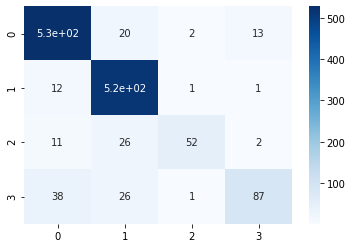

In [0]:
# 評価データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.show()

## 56. 適合率，再現率，F1スコアの計測
***
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
  # 適合率
  precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # 再現率
  recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores

In [0]:
pd.options.display.precision = 3  # 小数点以下3桁まで表示
calculate_scores(test['CATEGORY'], test_pred[1])

,適合率,再現率,F1スコア
b,0.896,0.938,0.917
e,0.878,0.974,0.923
t,0.845,0.572,0.682
m,0.929,0.571,0.707
マイクロ平均,0.885,0.885,0.885
マクロ平均,0.887,0.764,0.807


## 57. 特徴量の重みの確認
***
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [0]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,china,ecb,stocks,euro,obamacare,oil,yellen,dollar
重要度下位,video,ebola,the,her,and,she,apple,google,star,microsoft




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,her,movie,star,film,paul,he,wedding,she
重要度下位,us,update,google,study,china,gm,ceo,facebook,apple,says




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,cancer,drug,mers,fda,cases,cdc,could,cigarettes
重要度下位,facebook,gm,ceo,apple,bank,deal,google,sales,climate,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,gm,nasa,tesla,comcast,heartbleed
重要度下位,stocks,fed,her,percent,drug,american,cancer,ukraine,still,shares


## 58. 正則化パラメータの変更
***
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [0]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
  # モデルの学習
  lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = score_lg(lg, X_train)
  valid_pred = score_lg(lg, X_valid)
  test_pred = score_lg(lg, X_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
  test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [07:19<00:00, 43.92s/it]


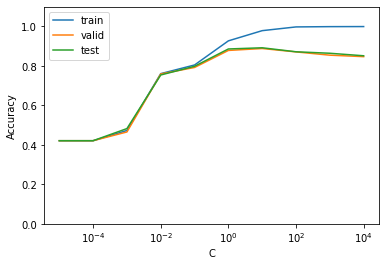

In [0]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索
***
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [0]:
!pip install optuna

In [0]:
import optuna

def objective_lg(trial):
  # チューニング対象パラメータのセット
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
  C = trial.suggest_loguniform('C', 1e-4, 1e4)

  # モデルの学習
  lg = LogisticRegression(random_state=123, 
                          max_iter=10000, 
                          penalty='elasticnet', 
                          solver='saga', 
                          l1_ratio=l1_ratio, 
                          C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  valid_pred = score_lg(lg, X_valid)

  # 正解率の算出
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])    

  return valid_accuracy 

In [0]:
# 最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective_lg, n_trials=100)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2020-06-02 13:12:15,016] Finished trial#0 with value: 0.6946107784431138 with parameters: {'l1_ratio': 0.2786621369347898, 'C': 0.03148194806021488}. Best is trial#0 with value: 0.6946107784431138.
[I 2020-06-02 13:12:19,571] Finished trial#1 with value: 0.39595808383233533 with parameters: {'l1_ratio': 0.8166939865275183, 'C': 0.0008254561137681635}. Best is trial#0 with value: 0.6946107784431138.
[I 2020-06-02 13:22:27,858] Finished trial#2 with value: 0.8697604790419161 with parameters: {'l1_ratio': 0.47348784731468985, 'C': 109.07950220537681}. Best is trial#2 with value: 0.8697604790419161.
[I 2020-06-02 13:22:55,130] Finished trial#3 with value: 0.4214071856287425 with parameters: {'l1_ratio': 0.9530383573562872, 'C': 0.012805115985323962}. Best is trial#2 with value: 0.8697604790419161.
[I 2020-06-02 13:23:18,068] Finished trial#4 with value: 0.530688622754491 with parameters: {'l1_ratio': 0.9837392930578511, 'C': 0.023224352713538805}. Best is trial#2 with value: 0.869760479

Best trial:
  Value: 0.892
  Params: 
    l1_ratio: 0.23568685768996045
    C: 4.92280374981671


In [0]:
# パラメータの設定
l1_ratio = trial.params['l1_ratio']
C = trial.params['C']

# モデルの学習
lg = LogisticRegression(random_state=123, 
                        max_iter=10000, 
                        penalty='elasticnet', 
                        solver='saga', 
                        l1_ratio=l1_ratio, 
                        C=C)
lg.fit(X_train, train['CATEGORY'])

# 予測値の取得
train_pred = score_lg(lg, X_train)
valid_pred = score_lg(lg, X_valid)
test_pred = score_lg(lg, X_test)

# 正解率の算出
train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1]) 
valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1]) 
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1]) 

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.966
正解率（検証データ）：0.892
正解率（評価データ）：0.895


In [0]:
!pip install xgboost

In [0]:
import xgboost as xgb

params={'objective': 'multi:softmax', 
        'num_class': 4,
        'eval_metric': 'mlogloss',
        'colsample_bytree': 1.0, 
        'colsample_bylevel': 0.5,
        'min_child_weight': 1,
        'subsample': 0.9, 
        'eta': 0.1, 
        'max_depth': 5,
        'gamma': 0.0,
        'alpha': 0.0,
        'lambda': 1.0,
        'num_round': 1000,
        'early_stopping_rounds': 50,
        'verbosity': 0
        }

# Xgboost用にフォーマット変換
category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x])
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x])
y_test = test['CATEGORY'].map(lambda x: category_dict[x])
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# 学習
num_round = params.pop('num_round')
early_stopping_rounds = params.pop('early_stopping_rounds')
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds)

[0]	train-mlogloss:1.32574	eval-mlogloss:1.32551
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 50 rounds.
[1]	train-mlogloss:1.27537	eval-mlogloss:1.27398
[2]	train-mlogloss:1.23015	eval-mlogloss:1.22829
[3]	train-mlogloss:1.19046	eval-mlogloss:1.18911
[4]	train-mlogloss:1.15536	eval-mlogloss:1.1545
[5]	train-mlogloss:1.12409	eval-mlogloss:1.12264
[6]	train-mlogloss:1.09592	eval-mlogloss:1.09459
[7]	train-mlogloss:1.07055	eval-mlogloss:1.0684
[8]	train-mlogloss:1.04774	eval-mlogloss:1.04566
[9]	train-mlogloss:1.02703	eval-mlogloss:1.02478
[10]	train-mlogloss:1.00831	eval-mlogloss:1.00644
[11]	train-mlogloss:0.991003	eval-mlogloss:0.989005
[12]	train-mlogloss:0.97481	eval-mlogloss:0.973309
[13]	train-mlogloss:0.959423	eval-mlogloss:0.958285
[14]	train-mlogloss:0.945742	eval-mlogloss:0.944163
[15]	train-mlogloss:0.932601	eval-mlogloss:0.931993
[16]	train-mlogloss:0.920568	eval-mlogloss:0.920045


In [0]:
# 予測値の取得
train_pred = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
valid_pred = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
test_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

# 正解率の算出
train_accuracy = accuracy_score(y_train, train_pred) 
valid_accuracy = accuracy_score(y_valid, valid_pred) 
test_accuracy = accuracy_score(y_test, test_pred) 

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.963
正解率（検証データ）：0.873
正解率（評価データ）：0.873
